Question 2) Find all the mentions of world countries in the whole corpus, 
using the pycountry utility (HINT: remember that there will be different surface forms 
for the same country in the text, e.g., Switzerland, switzerland, CH, etc.) 
Perform sentiment analysis on every email message using the demo methods 
in the nltk.sentiment.util module. Aggregate the polarity information of all 
the emails by country, and plot a histogram (ordered and colored by polarity level) 
that summarizes the perception of the different countries. Repeat the aggregation and plotting steps using different demo methods from the sentiment analysis module.
Can you find substantial differences?

In [7]:
import pandas as pd
import pycountry
from nltk.sentiment import *
import numpy as np
import matplotlib.pyplot as plt
import codecs
import math
import re
import string



AttributeError: module 'nltk' has no attribute 'data'

In [8]:
nltk.download()


NameError: name 'nltk' is not defined

Pre Process the Data, Dropping Irrelevant Columns

In [16]:
emails = pd.read_csv("hillary-clinton-emails/Emails.csv")


In [17]:
# Drop columns that won't be used
emails = emails.drop(['DocNumber', 'MetadataPdfLink','DocNumber', 'ExtractedDocNumber', 'MetadataCaseNumber'], axis=1)
emails.head()

,Id,MetadataSubject,MetadataTo,MetadataFrom,SenderPersonId,MetadataDateSent,MetadataDateReleased,MetadataDocumentClass,ExtractedSubject,ExtractedTo,ExtractedFrom,ExtractedCc,ExtractedDateSent,ExtractedCaseNumber,ExtractedDateReleased,ExtractedReleaseInPartOrFull,ExtractedBodyText,RawText
0,1,WOW,H,"Sullivan, Jacob J",87.0,2012-09-12T04:00:00+00:00,2015-05-22T04:00:00+00:00,HRC_Email_296,FW: Wow,NaN,"Sullivan, Jacob J <Sullivan11@state.gov>",NaN,"Wednesday, September 12, 2012 10:16 AM",F-2015-04841,05/13/2015,RELEASE IN FULL,NaN,UNCLASSIFIED\nU.S. Department of State\nCase N...
1,2,H: LATEST: HOW SYRIA IS AIDING QADDAFI AND MOR...,H,NaN,NaN,2011-03-03T05:00:00+00:00,2015-05-22T04:00:00+00:00,HRC_Email_296,NaN,NaN,NaN,NaN,NaN,F-2015-04841,05/13/2015,RELEASE IN PART,"B6\nThursday, March 3, 2011 9:45 PM\nH: Latest...",UNCLASSIFIED\nU.S. Department of State\nCase N...
2,3,CHRIS STEVENS,;H,"Mills, Cheryl D",32.0,2012-09-12T04:00:00+00:00,2015-05-22T04:00:00+00:00,HRC_Email_296,Re: Chris Stevens,B6,"Mills, Cheryl D <MillsCD@state.gov>","Abedin, Huma","Wednesday, September 12, 2012 11:52 AM",F-2015-04841,05/14/2015,RELEASE IN PART,Thx,UNCLASSIFIED\nU.S. Department of State\nCase N...
3,4,CAIRO CONDEMNATION - FINAL,H,"Mills, Cheryl D",32.0,2012-09-12T04:00:00+00:00,2015-05-22T04:00:00+00:00,HRC_Email_296,FVV: Cairo Condemnation - Final,NaN,"Mills, Cheryl D <MillsCD@state.gov>","Mitchell, Andrew B","Wednesday, September 12,2012 12:44 PM",F-2015-04841,05/13/2015,RELEASE IN PART,NaN,UNCLASSIFIED\nU.S. Department of State\nCase N...
4,5,H: LATEST: HOW SYRIA IS AIDING QADDAFI AND MOR...,"Abedin, Huma",H,80.0,2011-03-11T05:00:00+00:00,2015-05-22T04:00:00+00:00,HRC_Email_296,NaN,NaN,NaN,NaN,NaN,F-2015-04841,05/13/2015,RELEASE IN PART,"H <hrod17@clintonemail.com>\nFriday, March 11,...",B6\nUNCLASSIFIED\nU.S. Department of State\nCa...


In [18]:
emails_cut = emails[['ExtractedBodyText']].copy()
emails_cut.head()

,ExtractedBodyText
0,NaN
1,"B6\nThursday, March 3, 2011 9:45 PM\nH: Latest..."
2,Thx
3,NaN
4,"H <hrod17@clintonemail.com>\nFriday, March 11,..."


In [19]:
emails_cut = emails_cut.dropna()
emails_cut.head()


,ExtractedBodyText
1,"B6\nThursday, March 3, 2011 9:45 PM\nH: Latest..."
2,Thx
4,"H <hrod17@clintonemail.com>\nFriday, March 11,..."
5,Pis print.\n-•-...-^\nH < hrod17@clintonernail...
7,"H <hrod17@clintonemail.corn>\nFriday, March 11..."


Now we must tokenize the data...

In [20]:
from nltk import word_tokenize
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
tokenizer = RegexpTokenizer(r'\w+')

In [21]:
emails_tokenized = emails_cut.copy()
for index, row in emails_tokenized.iterrows():
    row['ExtractedBodyText'] = tokenizer.tokenize(row['ExtractedBodyText'])
emails_tokenized.columns = ['TokenizedText']
emails_tokenized.reset_index(drop=True, inplace=True)
emails_tokenized.head()

,TokenizedText
0,"[B6, Thursday, March, 3, 2011, 9, 45, PM, H, L..."
1,[Thx]
2,"[H, hrod17, clintonemail, com, Friday, March, ..."
3,"[Pis, print, H, hrod17, clintonernailcom, Wedn..."
4,"[H, hrod17, clintonemail, corn, Friday, March,..."


Figure out what words to remove...

In [81]:
words_delete = ['IT', 'RE','LA','AND', 'AM', 'AT', 'IN', 'I', 'ME', 'DO', 
                'A', 'AN','BUT', 'IF', 'OR','AS','OF','BY', 'TO', 'UP','ON','ANY', 'NO', 'NOR', 'NOT','SO',
                'S', 'T','DON','D', 'LL', 'M', 'O','VE', 'Y','PM', 'TV','CD','PA','ET', 'BY', 'IE','MS', 'MP', 'CC', 
                'GA','VA', 'BI','CV', 'AL','VAT', 'VA','AI', 'MD', 'SM', 'FM', 'EST', 'BB', 'BRB', 'AQ', 'MA', 'MAR', 'JAM', 'BM', 
                'Lybia', 'LY', 'LBY', 'MC', 'MCO', 'MO', 'MAC', 'NC', 'PG', 'PNG', 'SUR', 'VI'] 
# from part one we can see some words (from stopwords) that may end up as country abbreviations 
#as well as analysis of weird data we got down the line
#also weird errors occuring with Lybia, so it was excluded (odd given a lot of the controversy was about Lybia...)

emails_no_stop = emails_tokenized.copy()
emails_no_stop['TokenizedText'] = emails_no_stop['TokenizedText'].apply(lambda x: [item for item in x if item not in words_delete])
emails_no_stop.tail()

,TokenizedText
6737,"[Hi, Sorry, haven, t, had, a, chance, to, see,..."
6738,"[B6, assume, you, saw, this, by, now, if, not,..."
6739,"[Big, change, of, plans, in, the, Senate, Sena..."
6740,"[PVerveer, B6, Friday, December, 17, 2010, 12,..."
6741,"[See, below]"


In [82]:
#Make sure to Capitalize all words
for email in emails_no_stop['TokenizedText']:
    for word in email:
        word.title()
        
emails_no_stop['TokenizedText'].head()

0    [B6, Thursday, March, 3, 2011, 9, 45, H, Lates...
1                                                [Thx]
2    [H, hrod17, clintonemail, com, Friday, March, ...
3    [Pis, print, H, hrod17, clintonernailcom, Wedn...
4    [H, hrod17, clintonemail, corn, Friday, March,...
Name: TokenizedText, dtype: object

Create list of countries

In [83]:
countries_cited = []
for emails in emails_no_stop['TokenizedText']:
    for word in emails:
        try:
            country_name = pycountry.countries.get(alpha_2=word)
            countries_cited.append(country_name.name)
        except KeyError:
            try:
                country_name = pycountry.countries.get(alpha_3=word)
                countries_cited.append(country_name.name)
            except KeyError:
                try:
                    country = pycountry.countries.get(name=word)
                    countries_cited.append(country_name.name)
                except KeyError: pass


Organize List and Count Occurrence of Each Country

In [84]:
#List with Unique Entries of Countries Cited
final_countries = list(set(countries_cited))
size = len(final_countries)
final_countries

['Comoros',
 'Hong Kong',
 'Czechia',
 'Korea, Republic of',
 'Bahamas',
 'Azerbaijan',
 'Peru',
 'Mongolia',
 'Thailand',
 'Bosnia and Herzegovina',
 'Namibia',
 'Mauritius',
 'Svalbard and Jan Mayen',
 'Saudi Arabia',
 'Cayman Islands',
 'Philippines',
 'Malaysia',
 'Denmark',
 'Sierra Leone',
 'Iceland',
 'Costa Rica',
 'Kiribati',
 'Belgium',
 'Japan',
 'Jordan',
 'Palestine, State of',
 'Finland',
 'Sudan',
 'Portugal',
 'Madagascar',
 'United States',
 'Congo',
 'Cameroon',
 'Trinidad and Tobago',
 'British Indian Ocean Territory',
 'Australia',
 'Gambia',
 'United Kingdom',
 'Georgia',
 'Serbia',
 'Afghanistan',
 'Faroe Islands',
 'Ecuador',
 'Gibraltar',
 'Singapore',
 'Brunei Darussalam',
 'Suriname',
 'Canada',
 'Brazil',
 'Israel',
 'China',
 'Puerto Rico',
 'Tuvalu',
 'Colombia',
 'Seychelles',
 'Marshall Islands',
 'Romania',
 'Qatar',
 'Russian Federation',
 'Lithuania',
 'Switzerland',
 'New Zealand',
 'Nigeria',
 'Kenya',
 'Turkmenistan',
 'Hungary',
 'Somalia',
 'Cuba'

In [85]:
#Create New DataFrame for the Counts
Country_Sent = pd.DataFrame(index=range(0,size),columns=['Country', 'Count'])
Country_Sent['Country']=final_countries
Country_Sent.head()

,Country,Count
0,Comoros,NaN
1,Hong Kong,NaN
2,Czechia,NaN
3,"Korea, Republic of",NaN
4,Bahamas,NaN


In [86]:
count_list = []
for country in Country_Sent['Country']:
    count = countries_cited.count(country)
    count_list.append(count)
    
Country_Sent['Count']=count_list
Country_Sent.head()



,Country,Count
0,Comoros,9
1,Hong Kong,1
2,Czechia,3
3,"Korea, Republic of",1
4,Bahamas,7


In [87]:
#Take Out Countries with Less than 20 Citations
Country_Sent= Country_Sent[Country_Sent['Count'] > 14]
Country_Sent.head()


,Country,Count
5,Azerbaijan,17
6,Peru,26
10,Namibia,82
17,Denmark,49
18,Sierra Leone,20


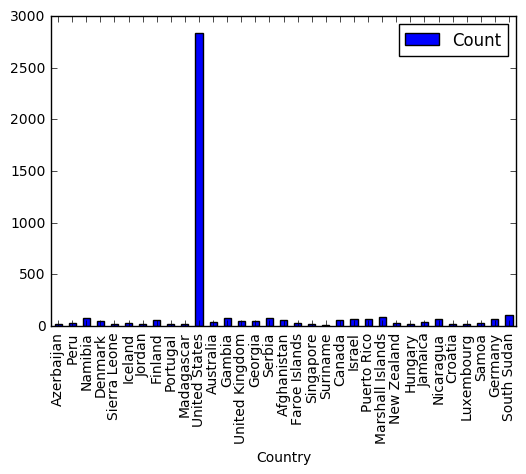

In [88]:
#plot to see frequencies
Country_Sent.plot.bar(x='Country', y='Count')
plt.show()

#We have repeatedly plotted this, identifying weird occurances (small countries with high counts), 
#and then elimitating them from the data set and repating the process

In [89]:
#create a list with all possible names of the countries above
countries_used = []
for country in Country_Sent['Country']:
    country_names = pycountry.countries.get(name=country)
    countries_used.append(country_names.name)
    countries_used.append(country_names.alpha_2)
    countries_used.append(country_names.alpha_3)

countries_used

['Azerbaijan',
 'AZ',
 'AZE',
 'Peru',
 'PE',
 'PER',
 'Namibia',
 'NA',
 'NAM',
 'Denmark',
 'DK',
 'DNK',
 'Sierra Leone',
 'SL',
 'SLE',
 'Iceland',
 'IS',
 'ISL',
 'Jordan',
 'JO',
 'JOR',
 'Finland',
 'FI',
 'FIN',
 'Portugal',
 'PT',
 'PRT',
 'Madagascar',
 'MG',
 'MDG',
 'United States',
 'US',
 'USA',
 'Australia',
 'AU',
 'AUS',
 'Gambia',
 'GM',
 'GMB',
 'United Kingdom',
 'GB',
 'GBR',
 'Georgia',
 'GE',
 'GEO',
 'Serbia',
 'RS',
 'SRB',
 'Afghanistan',
 'AF',
 'AFG',
 'Faroe Islands',
 'FO',
 'FRO',
 'Singapore',
 'SG',
 'SGP',
 'Suriname',
 'SR',
 'SUR',
 'Canada',
 'CA',
 'CAN',
 'Israel',
 'IL',
 'ISR',
 'Puerto Rico',
 'PR',
 'PRI',
 'Marshall Islands',
 'MH',
 'MHL',
 'New Zealand',
 'NZ',
 'NZL',
 'Hungary',
 'HU',
 'HUN',
 'Jamaica',
 'JM',
 'JAM',
 'Nicaragua',
 'NI',
 'NIC',
 'Croatia',
 'HR',
 'HRV',
 'Luxembourg',
 'LU',
 'LUX',
 'Samoa',
 'WS',
 'WSM',
 'Germany',
 'DE',
 'DEU',
 'South Sudan',
 'SS',
 'SSD']

Now we check sentiment on emails around these names

In [119]:
sentiments = []
vader_analyzer = SentimentIntensityAnalyzer()

for country in countries_used:
    country_names=[]
    try:
        country_name = pycountry.countries.get(alpha_2=country)
        country_names.append(country_name.alpha_2)    
    except KeyError:
            try:
                country_name = pycountry.countries.get(alpha_3=country)
                country_names.append(country_name.alpha_3)
            except KeyError:
                try:
                    country_name = pycountry.countries.get(name=country)
                    country_names.append(country_name.name)
                except KeyError:
                    country_names.append('NaN')
    country_score =[]
    for name in country_names:
        for email in emails_no_stop['TokenizedText']:
            if name in email:
                sentiment = vader_analyzer.polarity_scores(str_email)
                print(sentiment)
                score = sentiment['compound']
                country_score.append(score)
            else: pass
        if len(country_score) !=0: 
            sentiment_score = sum(country_score) / float(len(country_score))
            sentiments.append(sentiment_score)
        else:
            sentiment_score = 9999
            sentiments.append(sentiment_score)
        
        

            
sentiments
            
              
        

{'compound': 0.0, 'pos': 0.0, 'neu': 1.0, 'neg': 0.0}
{'compound': 0.0, 'pos': 0.0, 'neu': 1.0, 'neg': 0.0}
{'compound': 0.0, 'pos': 0.0, 'neu': 1.0, 'neg': 0.0}
{'compound': 0.0, 'pos': 0.0, 'neu': 1.0, 'neg': 0.0}
{'compound': 0.0, 'pos': 0.0, 'neu': 1.0, 'neg': 0.0}
{'compound': 0.0, 'pos': 0.0, 'neu': 1.0, 'neg': 0.0}
{'compound': 0.0, 'pos': 0.0, 'neu': 1.0, 'neg': 0.0}
{'compound': 0.0, 'pos': 0.0, 'neu': 1.0, 'neg': 0.0}
{'compound': 0.0, 'pos': 0.0, 'neu': 1.0, 'neg': 0.0}
{'compound': 0.0, 'pos': 0.0, 'neu': 1.0, 'neg': 0.0}
{'compound': 0.0, 'pos': 0.0, 'neu': 1.0, 'neg': 0.0}
{'compound': 0.0, 'pos': 0.0, 'neu': 1.0, 'neg': 0.0}
{'compound': 0.0, 'pos': 0.0, 'neu': 1.0, 'neg': 0.0}
{'compound': 0.0, 'pos': 0.0, 'neu': 1.0, 'neg': 0.0}
{'compound': 0.0, 'pos': 0.0, 'neu': 1.0, 'neg': 0.0}
{'compound': 0.0, 'pos': 0.0, 'neu': 1.0, 'neg': 0.0}
{'compound': 0.0, 'pos': 0.0, 'neu': 1.0, 'neg': 0.0}
{'compound': 0.0, 'pos': 0.0, 'neu': 1.0, 'neg': 0.0}
{'compound': 0.0, 'pos': 0.0

[0.0,
 0.0,
 9999,
 0.0,
 0.0,
 9999,
 9999,
 0.0,
 0.0,
 0.0,
 0.0,
 9999,
 9999,
 0.0,
 9999,
 0.0,
 0.0,
 9999,
 0.0,
 0.0,
 9999,
 0.0,
 9999,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 9999,
 9999,
 0.0,
 0.0,
 0.0,
 0.0,
 9999,
 9999,
 0.0,
 9999,
 9999,
 0.0,
 9999,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 9999,
 0.0,
 0.0,
 9999,
 9999,
 0.0,
 9999,
 0.0,
 0.0,
 9999,
 0.0,
 0.0,
 9999,
 0.0,
 0.0,
 9999,
 0.0,
 0.0,
 9999,
 9999,
 0.0,
 9999,
 9999,
 0.0,
 9999,
 9999,
 0.0,
 9999,
 0.0,
 9999,
 0.0,
 0.0,
 0.0,
 9999,
 0.0,
 0.0,
 9999,
 9999,
 0.0,
 9999,
 0.0,
 0.0,
 9999,
 0.0,
 0.0,
 9999,
 0.0,
 0.0,
 9999,
 9999,
 0.0,
 9999]

In [3]:
SentimentIntensityAnalyzer()
text = ['I hate going to th parties']
sentiment = SentimentIntensityAnalyzer().polarity_scores(text)
print(sentiment)

NameError: name 'SentimentIntensityAnalyzer' is not defined